0.539578768849
0.736571428571
             precision    recall  f1-score   support

          0       0.72      0.78      0.75     35021
          1       0.76      0.70      0.73     34979

avg / total       0.74      0.74      0.74     70000



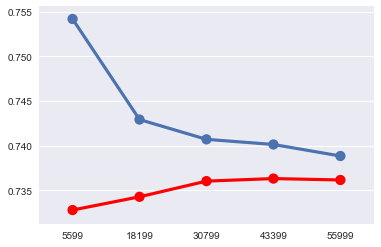

In [20]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

train = pd.read_csv('./train.csv', sep=';')
test = pd.read_csv('./test.csv', sep=';')
answer = train.cardio

complete = pd.concat([train, test])
complete = complete.drop(['id', 'cardio'], axis=1)
complete.loc[complete['active'] == 'None', 'active'] = np.NaN
complete.loc[complete['alco'] == 'None', 'alco'] = np.NaN
complete.loc[complete['smoke'] == 'None', 'smoke'] = np.NaN
complete['active'] = complete['active'].astype('float')
complete['alco'] = complete['alco'].astype('float')
complete['smoke'] = complete['smoke'].astype('float')

train = complete.head(len(train))
test = complete.tail(len(test))

import numpy as np
from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.model_selection import cross_val_predict, learning_curve

model = XGBClassifier()
predictions = cross_val_predict(model, train, answer, cv=5)
proba_predictions = cross_val_predict(model, train, answer, cv=5, method='predict_proba')

print log_loss(answer, proba_predictions)
print accuracy_score(answer, predictions)
print classification_report(answer, predictions)

train_sizes, train_scores, test_scores = learning_curve(model, train, answer, cv=5)

data = { 'x': train_sizes, 'y': map(lambda x: np.mean(x), train_scores) }
sns.pointplot(x='x', y='y', data=data)

data = { 'x': train_sizes, 'y': map(lambda x: np.mean(x), test_scores) }
sns.pointplot(x='x', y='y', data=data, color='red')

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

# def plot_boxes(cols, dato):
#     return map(lambda x: sns.boxplot(x='answer', y=x, data=dato, ax=plt.figure().add_subplot(111)), cols)

# [
#     sns.pairplot(knn_report[knn_report['predicted'] == knn_report['expected']], hue='expected', markers='+', plot_kws={'s': 1 }),
#     sns.pairplot(rr_report[rr_report['predicted'] == rr_report['expected']], hue='expected', markers='+', plot_kws={'s': 1 })
# ]

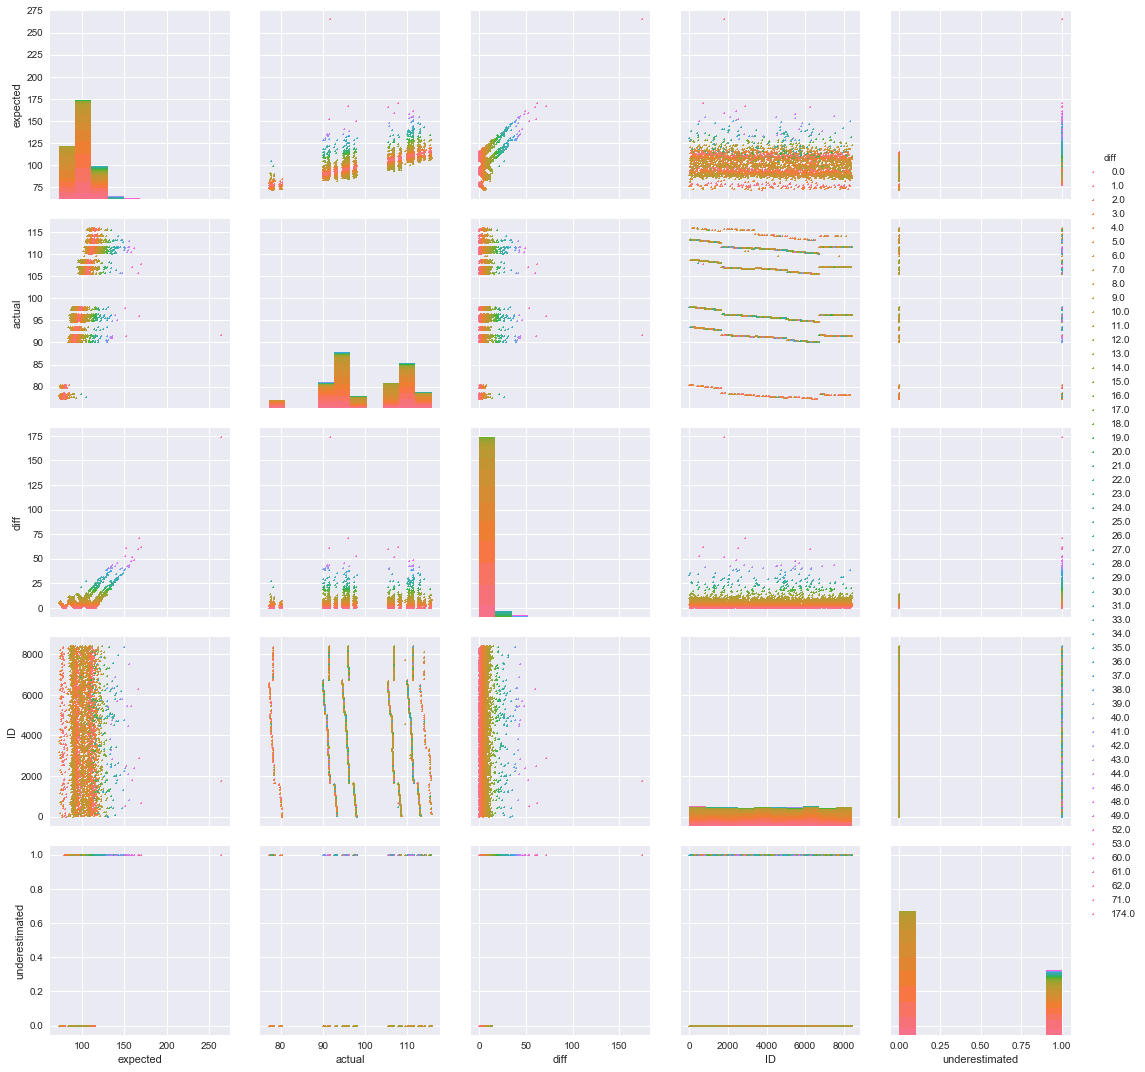

In [116]:
sns.pairplot(report[['expected', 'actual', 'diff', 'ID', 'underestimated']], markers='+', hue='diff', plot_kws={'s': 1}, size=3)

In [25]:
import time

model.fit(train, answer)
proba_predictions = model.predict_proba(test)

submission_response = pd.DataFrame({
    'y': proba_predictions[:,1]
})

timestr = time.strftime("%Y%m%d_%H%M")
pd.DataFrame(submission_response).to_csv('./outputs/naive.' + timestr + '.csv', header=False, index=False, line_terminator="\n")
pd.DataFrame(submission_response).to_csv('./outputs/_naive.latest.csv', header=False, index=False, line_terminator="\n")